In [1]:
#import packages
import mne
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import nilearn
import importlib
importlib.reload(plt)

%matplotlib inline

In [8]:
#%% PREPROCESSING FUNCTIONS, from prepare_for_classification

def preprocess_sensor_space_data(subject, date, raw_path,
                                 h_freq=40,
                                 tmin=-0.200, tmax=1.000, baseline=(None, 0),
                                 reject=None, decim=4):
    recording_names = ['001.self_block1',  '002.other_block1',
                       '003.self_block2',  '004.other_block2',
                       '005.self_block3',  '006.other_block3']
    epochs_list = list()
    for recording_index, recording_name in enumerate(recording_names):
        fif_fname = recording_name[4:]
        full_path = join(raw_path, subject, date, 'MEG', recording_name,
                         'files', fif_fname + '.fif')
        print(full_path)
        raw = mne.io.read_raw(full_path, preload=True)
        raw.filter(l_freq=None, h_freq=h_freq, n_jobs=3) # filtering
        
        events = mne.find_events(raw, min_duration=0.002)
        if 'self' in recording_name:
            event_id = dict(self_positive=11, self_negative=12,
                            button_press=23)
        elif 'other' in recording_name: 
            event_id = dict(other_positive=21, other_negative=22,
                            button_press=23)
        else:
            raise NameError('Event codes are not coded for file')
        epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline,
                            preload=True, decim=decim)
        epochs.pick_types(meg=True)
        
        epochs_list.append(epochs)
        
        if recording_index == 0:
            X = epochs.get_data()
            y = epochs.events[:, 2]
        else:
            X = np.concatenate((X, epochs.get_data()), axis=0)
            y = np.concatenate((y, epochs.events[:, 2]))
    
    return epochs_list


def preprocess_source_space_data(subject, date, raw_path, subjects_dir,
                                 epochs_list,
                              method='MNE', lambda2=1, pick_ori='normal',
                              label=None):
    if epochs_list is None:
        epochs_list = preprocess_sensor_space_data(subject, date, raw_path,
                                                   return_epochs=True)
    y = np.zeros(0)
    for epochs in epochs_list: # get y
        y = np.concatenate((y, epochs.events[:, 2]))
    
    if label is not None:
        label_path = join(subjects_dir, subject, 'label', label)
        label = mne.read_label(label_path)
        
    recording_names = ['001.self_block1',  '002.other_block1',
                       '003.self_block2',  '004.other_block2',
                       '005.self_block3',  '006.other_block3']
    for epochs_index, epochs in enumerate(epochs_list): ## get X
        
        fwd_fname = recording_names[epochs_index][4:] + '-oct-6-src-' + \
                    '5120-fwd.fif'
        fwd = mne.read_forward_solution(join(subjects_dir,
                                             subject, 'bem', fwd_fname))  # head model, forward solution
        noise_cov = mne.compute_covariance(epochs, tmax=0.000)
        inv = mne.minimum_norm.make_inverse_operator(epochs.info,
                                                     fwd, noise_cov)
  
        stcs = mne.minimum_norm.apply_inverse_epochs(epochs, inv, lambda2, # source time courses for evoked responses
                                                     method, label,
                                                     pick_ori=pick_ori)
        for stc_index, stc in enumerate(stcs):
            this_data = stc.data
            if epochs_index == 0 and stc_index == 0:
                n_trials = len(stcs)
                n_vertices, n_samples = this_data.shape
                this_X = np.zeros(shape=(n_trials, n_vertices, n_samples))
            this_X[stc_index, :, :] = this_data
            
        if epochs_index == 0:
            X = this_X
        else:
            X = np.concatenate((X, this_X))
    return X, y

def get_X_and_y(epochs_list):
    for recording_index in range(len(epochs_list)):
        these_epochs = epochs_list[recording_index]
        if recording_index == 0:
            X = these_epochs.get_data()
            y = these_epochs.events[:, 2]
        else:
            X = np.concatenate((X, these_epochs.get_data()), axis=0)
            y = np.concatenate((y, these_epochs.events[:, 2]))
            
    return X, y

In [9]:
#%% PATHS FOR ANALYSIS

raw_path_folder = '/work/834761'
subject = '/work/835482' # freesurfer


#%% RUNNING FUNCTIONS

epochs_list = preprocess_sensor_space_data('0108', '20230928_000000',
        raw_path=raw_path_folder,
        decim=10)

times = epochs_list[0].times # get time points for later

X_sensor, y = get_X_and_y(epochs_list)

X_source, y = preprocess_source_space_data('0108', '20230928_000000',
        raw_path=raw_path_folder, 
        subjects_dir=subject,
        epochs_list=epochs_list)

X_lh_BA44, y = preprocess_source_space_data('0108', '20230928_000000',  # choosing area 44
        raw_path=raw_path_folder, 
        subjects_dir=subject,
        label='lh.BA44_exvivo.label', epochs_list=epochs_list)
        
    
X_lh_LOF, y = preprocess_source_space_data('0108', '20230928_000000',  #area 47, not labelled directly
        raw_path=raw_path_folder, 
        subjects_dir= subject,
        label='lh.lateralorbitofrontal.label', epochs_list=epochs_list)

/work/834761/0108/20230928_000000/MEG/001.self_block1/files/self_block1.fif
Opening raw data file /work/834761/0108/20230928_000000/MEG/001.self_block1/files/self_block1.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 74000 ... 452999 =     74.000 ...   452.999 secs
Ready.
Reading 0 ... 378999  =      0.000 ...   378.999 secs...


/tmp/ipykernel_397/3411514787.py:17: RuntimeWarning: This filename (/work/834761/0108/20230928_000000/MEG/001.self_block1/files/self_block1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  15 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    4.0s finished


158 events found
Event IDs: [ 11  12  23 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 120 events and 1201 original time points (prior to decimation) ...


/tmp/ipykernel_397/3411514787.py:32: RuntimeWarning: The measurement information indicates a low-pass frequency of 40.0 Hz. The decim=10 parameter will result in a sampling frequency of 100.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline,


0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
/work/834761/0108/20230928_000000/MEG/002.other_block1/files/other_block1.fif
Opening raw data file /work/834761/0108/20230928_000000/MEG/002.other_block1/files/other_block1.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 69000 ... 451999 =     69.000 ...   451.999 secs
Ready.
Reading 0 ... 382999  =      0.000 ...   382.999 secs...


/tmp/ipykernel_397/3411514787.py:17: RuntimeWarning: This filename (/work/834761/0108/20230928_000000/MEG/002.other_block1/files/other_block1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  69 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    3.3s finished


162 events found
Event IDs: [ 21  22  23 103 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 120 events and 1201 original time points (prior to decimation) ...


/tmp/ipykernel_397/3411514787.py:32: RuntimeWarning: The measurement information indicates a low-pass frequency of 40.0 Hz. The decim=10 parameter will result in a sampling frequency of 100.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline,


0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
/work/834761/0108/20230928_000000/MEG/003.self_block2/files/self_block2.fif
Opening raw data file /work/834761/0108/20230928_000000/MEG/003.self_block2/files/self_block2.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 45000 ... 422999 =     45.000 ...   422.999 secs
Ready.
Reading 0 ... 377999  =      0.000 ...   377.999 secs...


/tmp/ipykernel_397/3411514787.py:17: RuntimeWarning: This filename (/work/834761/0108/20230928_000000/MEG/003.self_block2/files/self_block2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  69 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    3.2s finished


161 events found
Event IDs: [ 11  12  23 103 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 120 events and 1201 original time points (prior to decimation) ...


/tmp/ipykernel_397/3411514787.py:32: RuntimeWarning: The measurement information indicates a low-pass frequency of 40.0 Hz. The decim=10 parameter will result in a sampling frequency of 100.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline,


0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
/work/834761/0108/20230928_000000/MEG/004.other_block2/files/other_block2.fif
Opening raw data file /work/834761/0108/20230928_000000/MEG/004.other_block2/files/other_block2.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 48000 ... 426999 =     48.000 ...   426.999 secs
Ready.
Reading 0 ... 378999  =      0.000 ...   378.999 secs...


/tmp/ipykernel_397/3411514787.py:17: RuntimeWarning: This filename (/work/834761/0108/20230928_000000/MEG/004.other_block2/files/other_block2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  69 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    3.3s finished


160 events found
Event IDs: [ 21  22  23 103 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 120 events and 1201 original time points (prior to decimation) ...


/tmp/ipykernel_397/3411514787.py:32: RuntimeWarning: The measurement information indicates a low-pass frequency of 40.0 Hz. The decim=10 parameter will result in a sampling frequency of 100.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline,


0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
/work/834761/0108/20230928_000000/MEG/005.self_block3/files/self_block3.fif
Opening raw data file /work/834761/0108/20230928_000000/MEG/005.self_block3/files/self_block3.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 44000 ... 424999 =     44.000 ...   424.999 secs
Ready.
Reading 0 ... 380999  =      0.000 ...   380.999 secs...


/tmp/ipykernel_397/3411514787.py:17: RuntimeWarning: This filename (/work/834761/0108/20230928_000000/MEG/005.self_block3/files/self_block3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  69 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    3.2s finished


162 events found
Event IDs: [ 11  12  23 103 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 120 events and 1201 original time points (prior to decimation) ...


/tmp/ipykernel_397/3411514787.py:32: RuntimeWarning: The measurement information indicates a low-pass frequency of 40.0 Hz. The decim=10 parameter will result in a sampling frequency of 100.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline,


0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
/work/834761/0108/20230928_000000/MEG/006.other_block3/files/other_block3.fif
Opening raw data file /work/834761/0108/20230928_000000/MEG/006.other_block3/files/other_block3.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 12000 ... 398999 =     12.000 ...   398.999 secs
Ready.
Reading 0 ... 386999  =      0.000 ...   386.999 secs...


/tmp/ipykernel_397/3411514787.py:17: RuntimeWarning: This filename (/work/834761/0108/20230928_000000/MEG/006.other_block3/files/other_block3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  69 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    3.4s finished


160 events found
Event IDs: [ 21  22  23 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 120 events and 1201 original time points (prior to decimation) ...


/tmp/ipykernel_397/3411514787.py:32: RuntimeWarning: The measurement information indicates a low-pass frequency of 40.0 Hz. The decim=10 parameter will result in a sampling frequency of 100.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline,


0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Reading forward solution from /work/835482/0108/bem/self_block1-oct-6-src-5120-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (8196 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Computing rank from data with rank=None
    Using tolerance 2.7e-09 (2.2e-16 eps * 306 dim * 4e+04  max singular value)
    Estimated rank (mag + grad): 297
    MEG: rank 297 computed from 306 data channels with 9 projectors
    Created an SSP operator (subspace dimension = 9)
    Setting small MEG eigen

In [10]:
#%% SIMPLE CLASSIFICATION functions

def get_indices(y, triggers):
    indices = list()
    for trigger_index, trigger in enumerate(y):
        if trigger in triggers:
            indices.append(trigger_index)
            
    return indices

def equalize_number_of_indices(X, y):
    """
    Balances the class weight by removing trials so each class has the same number of trials as the class with the least trials.

    Parameters
    ----------
    X : array
        Data array with shape (n_trials, x, x)
    y : array
        Array with shape (n_trials, ) containing several classes

    Returns
    -------
    X_equal : array
        Data array with shape (n_trials, x, x) with equal number of trials for each class
    y_equal : array
        Array with shape (n_trials, ) containing classes with equal number of trials for each class

    """
    keys, counts = np.unique(y, return_counts = True)

    keep_inds = []

    for key in keys:
        index = np.where(np.array(y) == key)
        random_choices = np.random.choice(index[0], size = counts.min(), replace=False)
        keep_inds.extend(random_choices)
    
    X_equal = X[keep_inds, :, :]
    y_equal = y[keep_inds]

    return X_equal, y_equal

def simple_classication(X, y, triggers, penalty='none', C=1.0):

    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import cross_val_score, StratifiedKFold
    
    n_samples = X.shape[2]
    indices = get_indices(y, triggers)
    
    X, y = equalize_number_of_indices(X, y) # using the equalize function on x and y
    
    X = X[indices, :, :]
    y = y[indices]
    logr = LogisticRegression(penalty=penalty, C=C, solver='newton-cg')
    sc = StandardScaler() # especially necessary for sensor space as
                          ## magnetometers
                          # and gradiometers are on different scales 
                          ## (T and T/m)
    cv = StratifiedKFold()
    
    mean_scores = np.zeros(n_samples)
    
    for sample_index in range(n_samples):
        this_X = X[:, :, sample_index]
        sc.fit(this_X)
        this_X_std = sc.transform(this_X)
        scores = cross_val_score(logr, this_X_std, y, cv=cv)
        mean_scores[sample_index] = np.mean(scores)
        print(sample_index)
        
    return mean_scores

def plot_classfication(times, mean_scores, title=None):

    plt.figure()
    plt.plot(times, mean_scores)
    plt.hlines(0.50, times[0], times[-1], linestyle='dashed', color='k')
    plt.ylabel('Proportion classified correctly')
    plt.xlabel('Time (s)')
    if title is None:
        pass
    else:
        plt.title(title)
    plt.show()


In [11]:

#%% COLLAPSE EVENTS 

def collapse_events(y, new_value, old_values=list()):
    new_y = y.copy()
    for old_value in old_values:
        new_y[new_y == old_value] = new_value
    return new_y


positive_y = collapse_events(y, 1, [11, 21])
negative_y = collapse_events(y, 2, [12, 22])
self_y =     collapse_events(y, 3, [11, 12])
other_y =    collapse_events(y, 4, [21, 22])

pos_and_neg_y = collapse_events(positive_y, 2, [12, 22])
self_and_other_y = collapse_events(self_y, 4, [21, 22])

#%% CLASSIFCATION - COLLAPSED EVENTS

lh_BA44_self_other = simple_classication(X_lh_BA44,
                                  self_and_other_y, triggers=[3, 4],
                                  penalty='l2', C=1e-3)

lh_LOF_pos_neg = simple_classication(X_lh_LOF,
                                  pos_and_neg_y, triggers=[1, 2],
                                  penalty='l2', C=1e-3)


sensor_pos_neg = simple_classication(X_sensor,
                                  pos_and_neg_y, triggers=[1, 2],
                                  penalty='l2', C=1e-3)

sensor_self_other = simple_classication(X_sensor,
                                  self_and_other_y, triggers=[3, 4],
                                  penalty='l2', C=1e-3)

source_pos_neg = simple_classication(X_source, ## slow 
                                  pos_and_neg_y, triggers=[1, 2],
                                  penalty='l2', C=1e-3)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
8

KeyboardInterrupt: 

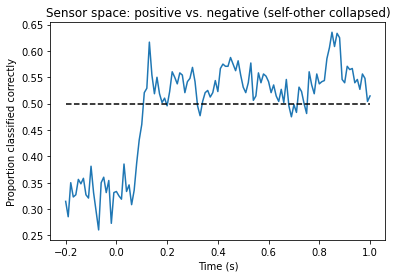

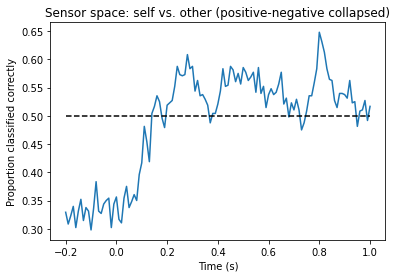

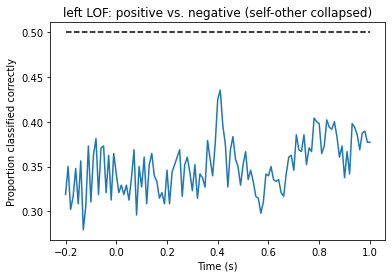

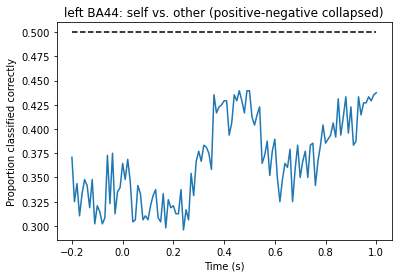

In [12]:
#%% PLOT COLLAPSED

plot_classfication(times, sensor_pos_neg,
                   title='Sensor space: positive vs. negative (self-other collapsed)')


plot_classfication(times, source_pos_neg,
                   title='Source space: positive vs. negative (self-other collapsed)')

plot_classfication(times, sensor_self_other,
                   title='Sensor space: self vs. other (positive-negative collapsed)')


plot_classfication(times, lh_LOF_pos_neg,
                   title='left LOF: positive vs. negative (self-other collapsed)')   #  change to new ba 47


plot_classfication(times, lh_BA44_self_other,
                   title='left BA44: self vs. other (positive-negative collapsed)') 
